# Entregable 1: Aprendizaje de Máquinas

Natalia Lara Davila

Se realizará un análisis de los datos obtenidos experimentalmente y mediante simulación del espectro de transmisión de una estructura interferométrica SMS (Singlemode–Multimode–Singlemode) basada en fibra óptica, cuyo diseño fue desarrollado utilizando el software FIMMWAVE.
A esta estructura se le aplicaron variaciones geométricas en la sección multimodo, así como cambios en el índice de refracción (RI) del medio circundante, con el objetivo de evaluar su comportamiento frente a modificaciones estructurales y analizar cómo estas influyen en la sensibilidad del sensor ante variaciones del índice de refracción externo.

A partir de los resultados obtenidos se llevará a cabo la extracción de características relevantes de los espectros simulados y experimentales, con el propósito de evaluar el desempeño de diferentes modelos de aprendizaje de máquina supervisados, tales como K-Nearest Neighbors (KNN), Árboles de Decisión, Random Forest y Gradient Boosting. El análisis permitirá identificar patrones en los espectros, clasificar las condiciones del sensor y determinar el modelo con mejor rendimiento, que posteriormente podrá ser optimizado para aplicaciones en sistemas de sensado óptico basados en estructuras SMS.

## Librerías a utilizar

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import re

#--------- Paquetes de modelos ---------#
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## Importar Dataset

El dataset contiene los espectros de transmisión obtenidos tanto mediante simulación numérica como por medición experimental de la estructura interferométrica SMS (Singlemode–Multimode–Singlemode), como se muestra a continuación.
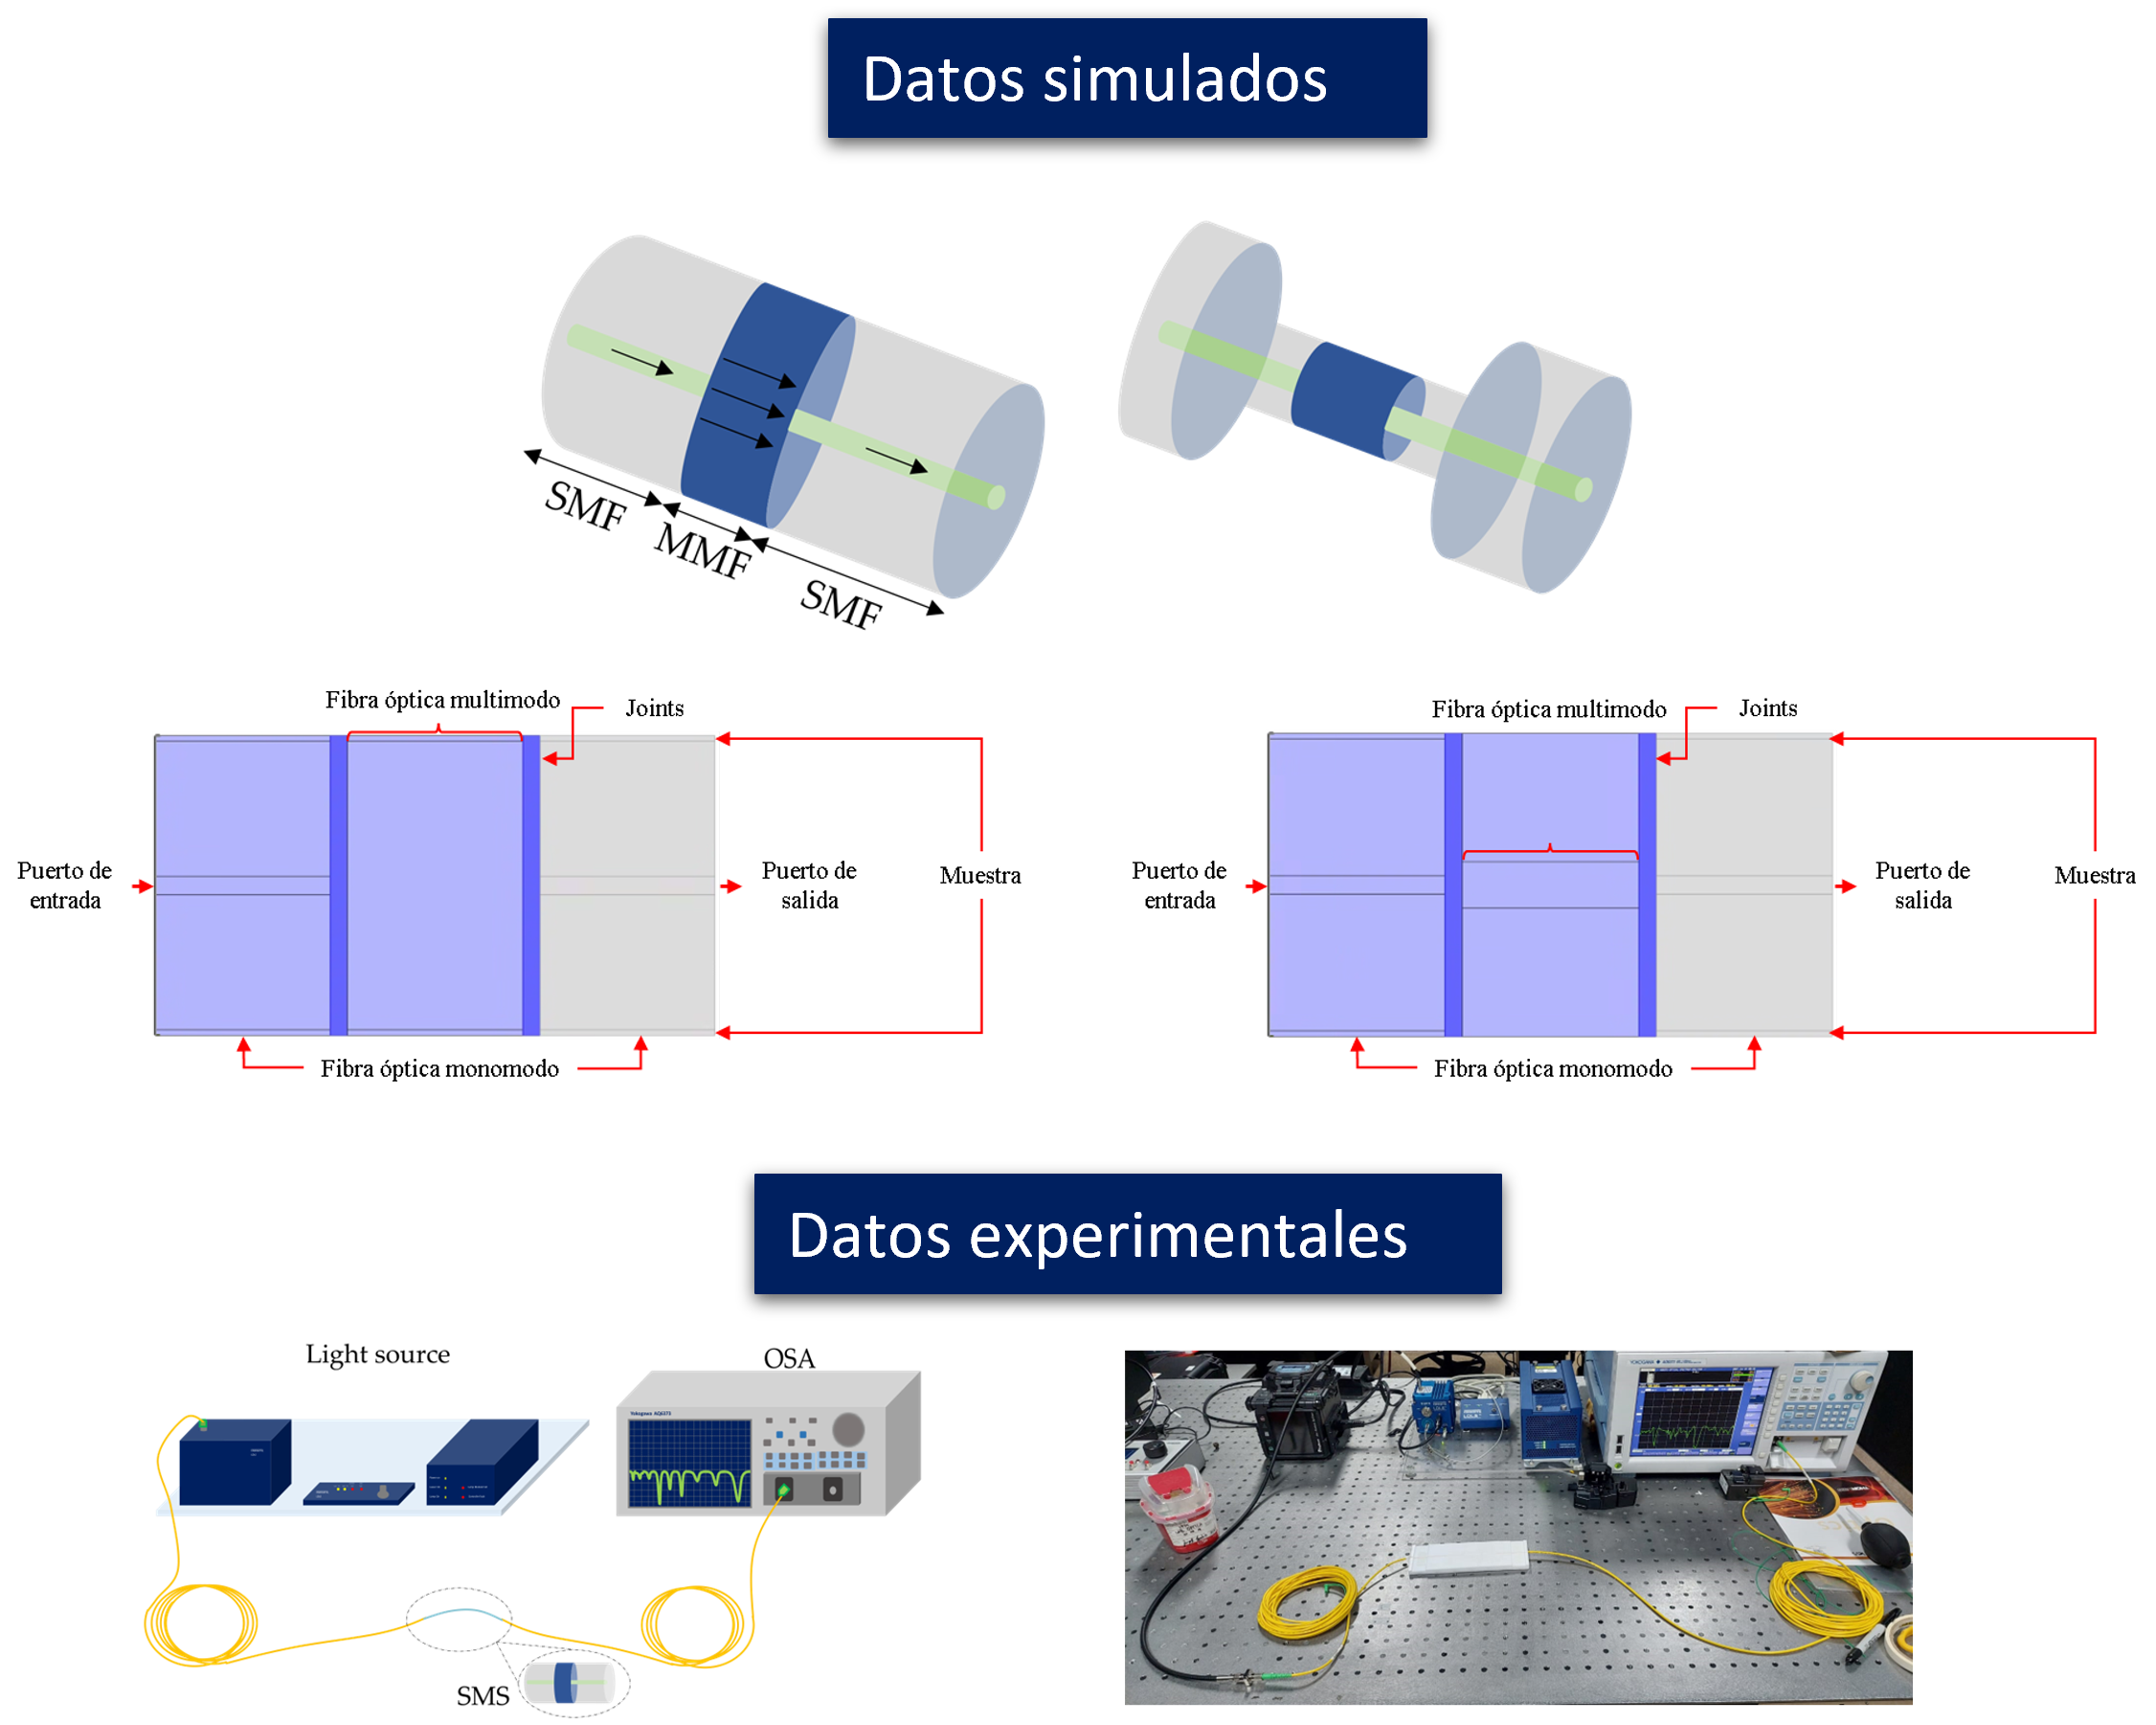

Cada columna del conjunto de datos, excepto la primera,  correspondiente a la longitud de onda (Wavelength) representa un espectro individual asociado a una condición específica del sensor.

La columna Wavelength abarca un rango aproximado de 600 a 1100 nm, cubriendo así el comportamiento del sensor en las regiones del visible y el infrarrojo cercano (NIR).

Los nombres de las columnas siguen una convención de codificación que describe las condiciones geométricas y ópticas bajo las cuales fue obtenido cada espectro. Un ejemplo de etiqueta es:

### **125_RI_1.39_Num**

**Donde:**
*   **125:** Representa el diametro de la fibra multimodo (MMF) en micrometros
*   **RI_1.33:** Indica el indice de refracción del medio circundante, en este ejemplo, corresponde a un valor de 1.33 (Agua)
*   **Num:** Indica que el espectro fue obtenido mediante simulación numérica (En contraste con EXp, que corresponde a datos experimentales).

De esta forma, las etiquetas de las columnas permiten identificar facilmente las condiciones geométricas y ópticas bajo las cuales fue obtenido el espectro.

In [26]:
Data = pd.read_excel('/content/drive/MyDrive/Maestría clases/SEMESTRE 3/ML/Entregable 1/Data.xlsx')

## Visualización Espectros de transmisión.

Con el fin de graficar los espectros de transmisión que comparten el mismo
diámetro pero con diferentes índices de refracción (RI) para analizar la
sensibilidad del sensor.
A partir de los nombres de las columnas del dataset, se extraen:
- Diameter -> el diámetro de la fibra (entero)
- RI -> el índice de refracción (float)
- TIPO -> el tipo de dato ('Num' o 'Exp')

Asimismo, en las funciones se usan operaciones de texto (split) para filtrar
qué espectros visualizar por diámetro, RI y tipo.

In [27]:
# Columna Longitud de onda (Wavelength), rango (600 - 1100)nm
wave_col = 'Wavelength'

def Diameter(columns):
    s = str(columns)
    if '_RI_' not in s:
        return None
    left = s.split('_RI_')[0]
    token = left.split('_')[-1].strip()
    try:
        return int(token)
    except ValueError:
        return None

def RI(columns):
    s = str(columns)
    if '_RI_' not in s:
        return None
    right = s.split('_RI_')[1]
    token = right.split('_')[0].replace(',', '.')
    try:
        return float(token)
    except ValueError:
        return None

def TIPO(columns):
    s = str(columns).lower()
    if 'exp' in s:
        return 'Exp'
    if 'num' in s or 'sim' in s:
        return 'Num'
    return 'NA'

def plot_espectros(Data, diameter, tipos=("Num","Exp"), ris=None, offset=0.0):
    sel = [c for c in Data.columns
           if c != wave_col
           and Diameter(c) == diameter
           and TIPO(c) in tipos
           and (ris is None or RI(c) in ris)]

    if not sel:
        return

    wavelength = pd.to_numeric(Data[wave_col], errors='coerce').to_numpy()

    plt.figure(figsize=(9,5))
    for i, c in enumerate(sel):
        y = pd.to_numeric(Data[c], errors='coerce').to_numpy()
        if offset:
            y = y + i*offset
        plt.plot(wavelength, y, label=f"{TIPO(c)} | RI={RI(c)}")

    plt.title(f"Espectros para diámetro {diameter} µm")
    plt.xlabel("Longitud de onda (nm)")
    plt.ylabel("Transmisión (dB)")
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()



In [ ]:
plot_espectros(Data, 125, ("Num"), offset = -10)                         # RIs
plot_espectros(Data, 125, ("Num"), ris=[1.33])  # solo simulados RI=1.33

## Extracción de características

Para cada espectro, se identifícan los 3 picos más relevantes definidos por su  mínimos de transmisión más profundos y, con menor FWHM (ancho a media altura).

Sobre esos picos extraemos y organizamos las siguientes características:
- Espectro: nombre exacto de la columna en el dataset.
- Diámetro (µm): Diametro obtenido del nombre de la columna.
- Índice de refracción: RI extraído del nombre de la columna.
- Tipo: Num (simulado) o Exp (experimental), y su versión binaria TipoBin (1 para Num, 0 para Exp).
- Número de pico: Si es el pico 1, 2 o 3.
- Características del pico: longitud de onda pico_wl, transmisión pico_tr y ancho pico_FWHM.
- Referencia y desplazamiento espectral: para cada diámetro y número de pico, tomamos como referencia el pico del espectro con RI= 1.0. Calculamos la distancia espectral como:
distancia_ref = pico_wl – ref_pico_wl

Ejemplo de desplazamiento espectral:  el pico #1 de un espectro con RI= 1.33 y diámetro= 125 µm se compara contra el pico #1 del espectro RI= 1.0 con el mismo diámetro.

In [28]:
## Definir en binario que tipo de datos son (SimulaDO O Experimental)

def TipoBinario(col):
    t = TIPO(col)
    if t == 'Num': return 1
    if t == 'Exp': return 0
    return np.nan


## Extracción de picos relevantes y parámetros como transmisión, longitud de onda y FWHM

def extraer_picos(wavelength, transmission, n_picos=3, prominence=0.001):

    x = np.asarray(wavelength, dtype=float)   # Longitud de onda (nm)
    y = np.asarray(transmission, dtype=float) # transmisión

    # Detecta valles como picos en -y (Profundidad mínima = prominente)
    peaks, _ = find_peaks(-y, prominence=prominence)
    if peaks.size == 0:
        return [], [], []


    # FWHM sobre -y
    widths, _, _, _ = peak_widths(-y, peaks, rel_height=0.5)

    # Ordenar los 3 picos prominentes por longitud de onda ascendente
    orden = np.argsort(x[peaks])
    peaks = peaks[orden][:n_picos]
    widths = widths[orden][:n_picos]

    # Empaquetar resultados
    wavelength_peak  = [float(x[i]) for i in peaks]
    transmission_peak  = [float(y[i]) for i in peaks]
    fwhm_peak= [float(w)    for w in widths]
    return wavelength_peak, transmission_peak, fwhm_peak

    ## Construcción de dataframe con caracteríssticas extraidas.

def Data_caracteristicas(Data, wavelength_col=wave_col, n_picos=3, prominence=0.001):

    # eje de longitudes de onda (nm)
    wavelength = pd.to_numeric(Data[wavelength_col], errors='coerce').to_numpy()


    # columnas de espectro menos la de longitud de onda
    cols_espectro = [c for c in Data.columns if c != wavelength_col]

    rows = []
    for col in cols_espectro:
        transm = pd.to_numeric(Data[col], errors='coerce').to_numpy()
        diam   = Diameter(col)
        ri     = RI(col)
        tipo   = TIPO(col)
        tipo_b = TipoBinario(col)

        # picos relevantes
        wl_p, tr_p, fwhm_p = extraer_picos(wavelength, transm,
                                           n_picos=n_picos, prominence=prominence)

        # una fila por pico encontrado
        for k, (wpk, tpk, fpk) in enumerate(zip(wl_p, tr_p, fwhm_p), start=1):
            rows.append({
                "Espectro": col,
                "Diametro": diam,
                "RI": ri,
                "Tipo": tipo,
                "TipoBin": tipo_b,
                "numero_de_pico": k,
                "pico_wl": wpk,
                "pico_tr": tpk,
                "pico_FWHM": fpk
            })

    Caracteristics = pd.DataFrame(rows)
    return Caracteristics

In [ ]:
Caracteristics = Data_caracteristicas(Data, wavelength_col=wave_col, n_picos=3, prominence=0.001)
Caracteristics.head()

In [ ]:
# Distancia espectral respecto a la refeencia
def Distancia_referencia(tabla: pd.DataFrame, tol: float = 1e-6) -> pd.DataFrame:
    if tabla.empty:
        tabla = tabla.copy()
        tabla["ref_pico_wl"] = np.nan
        tabla["distancia_ref"] = np.nan
        return tabla

    refs = (
        tabla.loc[np.isfinite(tabla["RI"]) & (np.abs(tabla["RI"] - 1.0) <= tol)]
             .dropna(subset=["pico_wl"])
             .groupby(["Diametro", "numero_de_pico"], as_index=False)["pico_wl"]
             .first()
             .rename(columns={"pico_wl": "ref_pico_wl"})
    )

    Referencia = tabla.merge(refs, on=["Diametro","numero_de_pico"], how="left")
    Referencia["distancia_ref"] = Referencia["pico_wl"] - Referencia["ref_pico_wl"]
    return Referencia


In [29]:
Caracteristics_Data = Data_caracteristicas(Data, wavelength_col=wave_col, n_picos=3, prominence=0.001)
Caracteristics_Data = Distancia_referencia(Caracteristics_Data)
Caracteristics_Data.head()

,Espectro,Diametro,RI,Tipo,TipoBin,numero_de_pico,pico_wl,pico_tr,pico_FWHM,ref_pico_wl,distancia_ref
0,125_RI_1_Num,125,1.00,Num,1,1,606.0,-49.901145,1.527516,606.0,0.0
1,125_RI_1_Num,125,1.00,Num,1,2,610.0,-49.973500,9.793322,610.0,0.0
2,125_RI_1_Num,125,1.00,Num,1,3,646.0,-28.931540,7.393268,646.0,0.0
3,125_RI_1.33_Num,125,1.33,Num,1,1,608.0,-49.640815,1.938763,606.0,2.0
4,125_RI_1.33_Num,125,1.33,Num,1,2,612.0,-51.121057,10.188539,610.0,2.0


## Análisis exploratorio de Datos

Se realiza el análisis exploratorio de datos a las características extraídas a partir de los espectros de transmisión obtenidos, con el fin de observar tendencias o patrones relacionados con el diámetro de la fibra, el índice de refracción (RI), el tipo de dato (simulado o experimental) y las propiedades de los picos detectados (longitud de onda, transmisión y ancho FWHM).

In [30]:
Caracteristics_Data.info()


# Saber que datos faltantes hay
print('Valores faltantes por columna:')
print(Caracteristics_Data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Espectro        120 non-null    object 
 1   Diametro        120 non-null    int64  
 2   RI              120 non-null    float64
 3   Tipo            120 non-null    object 
 4   TipoBin         120 non-null    int64  
 5   numero_de_pico  120 non-null    int64  
 6   pico_wl         120 non-null    float64
 7   pico_tr         120 non-null    float64
 8   pico_FWHM       120 non-null    float64
 9   ref_pico_wl     120 non-null    float64
 10  distancia_ref   120 non-null    float64
dtypes: float64(6), int64(3), object(2)
memory usage: 10.4+ KB
Valores faltantes por columna:
Espectro          0
Diametro          0
RI                0
Tipo              0
TipoBin           0
numero_de_pico    0
pico_wl           0
pico_tr           0
pico_FWHM         0
ref_pico_wl       0
distancia_ref   

In [31]:
## Resumen general: rango, promedio, mínimos, máximos y cantidad de datos válidos en cada columna

Caracteristics_Data.describe()

,Diametro,RI,TipoBin,numero_de_pico,pico_wl,pico_tr,pico_FWHM,ref_pico_wl,distancia_ref
count,120.000000,120.000000,120.000000,120.00000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,76.250000,1.268250,0.900000,2.00000,624.100000,-29.393155,5.211724,622.216667,1.883333
std,37.468474,0.179058,0.301258,0.81992,15.930732,19.445421,5.325978,14.865324,10.161869
min,20.000000,1.000000,0.000000,1.00000,601.000000,-63.390554,0.502486,603.000000,-37.000000
25%,40.000000,1.000000,1.000000,1.00000,610.000000,-50.251028,1.031328,609.000000,0.000000
50%,80.000000,1.360000,1.000000,2.00000,622.500000,-20.457731,2.528592,619.000000,3.000000
75%,106.250000,1.397500,1.000000,3.00000,635.250000,-13.893000,8.019561,635.000000,6.000000
max,125.000000,1.430000,1.000000,3.00000,660.000000,-8.756531,20.286870,646.000000,48.000000


- Teniendo en cuenta la transmisión promedio y la desviación estandar se observa que las profundidades de los picos vría significativamente dependiendo del diámetro y el RI.

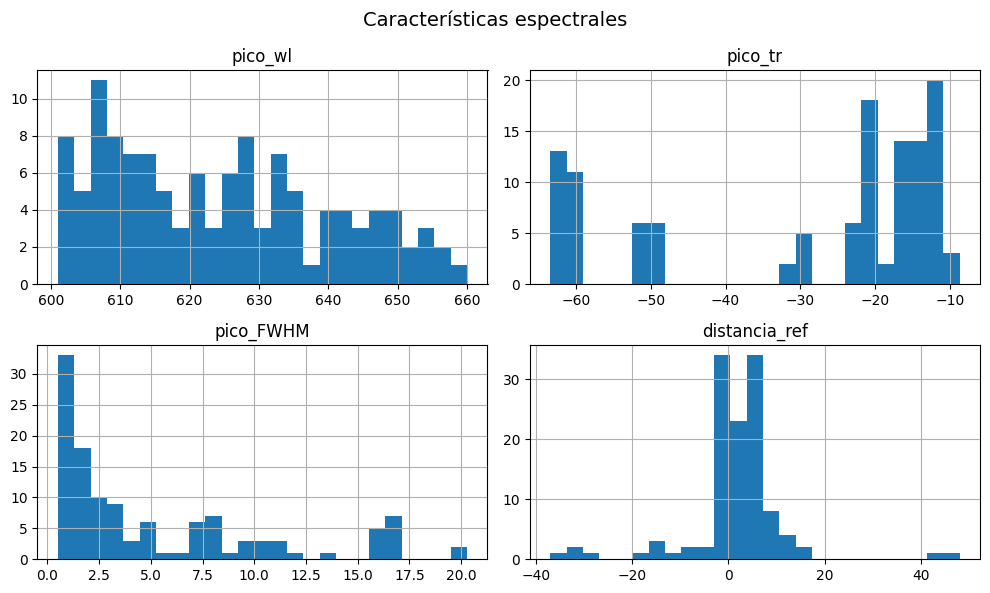

In [32]:
## Histograma con características principales.

Caracteristics_Data[["pico_wl", "pico_tr", "pico_FWHM", "distancia_ref"]].hist(bins=25, figsize=(10,6))
plt.suptitle("Características espectrales", fontsize=14)
plt.tight_layout()
plt.show()

- Al evalar el FWHM se evidencia que la mayoría de los picos son angostos y bien definidos, y sólo unos pocos presentan anchos grandes.
- Al evaluar la distancia de los picos aa diferentes RI respecto a la referencia se evidencia que es reducido pero aun se alcanza a ver.


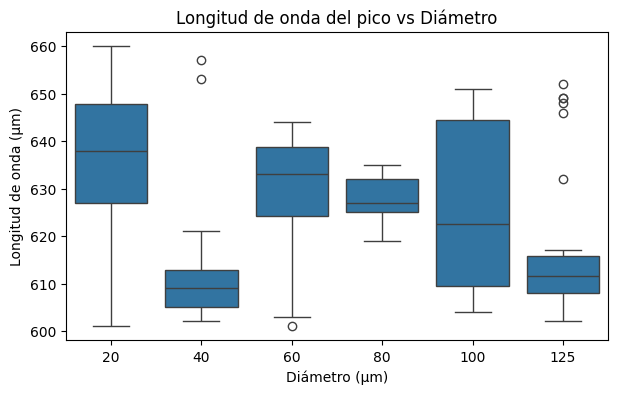

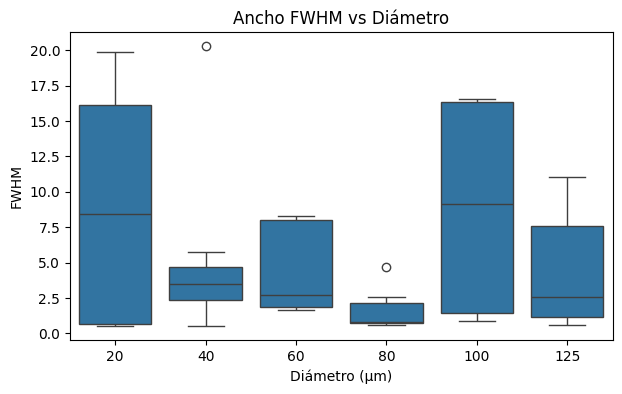

In [33]:

plt.figure(figsize=(7,4))
sns.boxplot(data=Caracteristics_Data, x="Diametro", y="pico_wl")
plt.title("Longitud de onda del pico vs Diámetro")
plt.xlabel("Diámetro (µm)")
plt.ylabel("Longitud de onda (µm)")
plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(data=Caracteristics_Data, x="Diametro", y="pico_FWHM")
plt.title("Ancho FWHM vs Diámetro")
plt.xlabel("Diámetro (µm)")
plt.ylabel("FWHM")
plt.show()



Se evidencian valores atípicos en la longitud de onda en los diámetros de 40 µm y 125 µm, con desplazamientos hacia 0.65 µm.
En el caso de 40 µm, estos valores no muestran una tendencia clara y podrían deberse a ruido en la detección del pico.
Sin embargo, para 125 µm, es posible que la presencia de datos experimentales influyan en esta dispersión, ya que las condiciones de medida reales suelen generar pequeñas diferencias espectrales respecto a los datos simulados.

De manera similar, en el ancho espectral FWHM, también se observan valores atípicos en los diámetros de 40 µm y 80 µm, lo que podría indicar picos menos definidos

## Preprocesamiento y preparación de datos

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [35]:
target_col = 'Diametro'

# Variables predictoras
numeric_features = ['pico_wl', 'pico_tr', 'pico_FWHM', 'distancia_ref']
categorical_features = ['numero_de_pico']

# === X e y ===
X = Caracteristics_Data[numeric_features + categorical_features].copy()
y = Caracteristics_Data[target_col].copy()

# Preprocesamiento
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])




In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, classification_report

In [36]:
# === División de datos ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (96, 5)  Test: (24, 5)


## Evaluar modelos

- KNN
- Arboles de desición
- Random Forest
- Gradient Boosting

### KNN y Arboles de desición

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluar_models(model, X_tra, y_tra, X_te, y_te, title=''):
    model.fit(X_tra, y_tra)
    y_pred = model.predict(X_te)

    print(f'\n=== {title} ===')
    print('Accuracy : ', accuracy_score(y_te, y_pred))
    print('Precision:', precision_score(y_te, y_pred, average='macro', zero_division=0))
    print('Recall   :', recall_score(y_te, y_pred, average='macro', zero_division=0))
    print('F1       :', f1_score(y_te, y_pred, average='macro', zero_division=0))


In [41]:
knn_pipe = Pipeline([('prep', preprocess),
                     ('clf', KNeighborsClassifier(n_neighbors=7))])

dt_pipe  = Pipeline([('prep', preprocess),
                     ('clf', DecisionTreeClassifier(random_state=42))])

evaluar_models(knn_pipe, X_train, y_train, X_test, y_test, title='KNN')
evaluar_models(dt_pipe,  X_train, y_train, X_test, y_test, title='Decision Tree')



=== KNN ===
Accuracy :  0.6666666666666666
Precision: 0.6583333333333333
Recall   : 0.6944444444444443
F1       : 0.6615079365079365

=== Decision Tree ===
Accuracy :  0.875
Precision: 0.875
Recall   : 0.9027777777777778
F1       : 0.8773809523809524


## Validación cruzada

In [38]:
RANDOM_STATE = 42

# CV estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def cv_report(pipe, X, y, scoring='f1_macro'):
    scores = cross_val_score(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"{scoring.upper()} CV: mean = {scores.mean():.3f}  std = {scores.std():.3f}")

print("KNN:")
_ = cv_report(knn_pipe, X, y, scoring='f1_macro')

print("DT:")
_ = cv_report(dt_pipe, X, y, scoring='f1_macro')

KNN:
F1_MACRO CV: mean = 0.688  std = 0.112
DT:
F1_MACRO CV: mean = 0.885  std = 0.036


### Random Forest y Gradient Boosting

In [39]:
def cv_report(pipe, X, y, scoring='f1_macro'):
    scores = cross_val_score(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"{scoring.upper()} CV: mean = {scores.mean():.3f}  std = {scores.std():.3f}")

# PREPROCESADO para árboles: solo imputación (sin escalado)
preprocess_tree = SimpleImputer(strategy='median')

rf_pipe = Pipeline(steps=[
    ('prep', preprocess_tree),
    ('clf', RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE))
])

gb_pipe = Pipeline(steps=[
    ('prep', preprocess_tree),
    ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

print("Random Forest:")
_ = cv_report(rf_pipe, X, y, scoring='f1_macro')

print("Gradient Boosting:")
_ = cv_report(gb_pipe, X, y, scoring='f1_macro')

Random Forest:
F1_MACRO CV: mean = 0.933  std = 0.025
Gradient Boosting:
F1_MACRO CV: mean = 0.915  std = 0.027


## Optimización de Hiperparámetros de los modelos

In [44]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

knn_grid = {
    'clf__n_neighbors': [1, 3, 5, 7, 9, 11, 15],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2],  # Manhattan/Euclidiana (minkowski)
}

knn_gs = GridSearchCV(knn_pipe, knn_grid, cv=cv, scoring='f1_macro', n_jobs=-1,
    error_score='raise',  verbose=1)

knn_gs.fit(X_train, y_train)
print("KNN best params:", knn_gs.best_params_, "best score", knn_gs.best_score_)



Fitting 5 folds for each of 28 candidates, totalling 140 fits
KNN best params: {'clf__n_neighbors': 3, 'clf__p': 1, 'clf__weights': 'distance'} best score 0.8441798941798941


In [52]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

dt_dist = {
    'clf__max_depth'        : randint(3, 16),
    'clf__min_samples_split': randint(5, 31),
    'clf__min_samples_leaf' : randint(2, 11),
    'clf__max_features'     : ['sqrt', 'log2', None],
    'clf__criterion'        : ['gini', 'log_loss'],
    'clf__ccp_alpha'        : uniform(0.0, 0.01), # poda
    'clf__splitter'         : ['best', 'random']
}

dt_rs = RandomizedSearchCV( estimator=dt_pipe, param_distributions=dt_dist, n_iter=100, cv=cv, scoring='f1_macro',
    n_jobs=-1, random_state=RANDOM_STATE, return_train_score=True, verbose=1)

dt_rs.fit(X_train, y_train)

print("Mejores params:", dt_rs.best_params_)
print("Mejor F1_macro (CV):", dt_rs.best_score_)

# Diagnóstico sobreajuste:
import pandas as pd
cvres = pd.DataFrame(dt_rs.cv_results_)
gap = (cvres['mean_train_score'] - cvres['mean_test_score']).abs()
print("Gap train-CV (prom):", gap.mean())

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejores params: {'clf__ccp_alpha': np.float64(0.005912977877077272), 'clf__criterion': 'log_loss', 'clf__max_depth': 13, 'clf__max_features': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 7, 'clf__splitter': 'best'}
Mejor F1_macro (CV): 0.8737950937950938
Gap train-CV (prom): 0.12734201296784967


In [53]:
evaluar_models(knn_gs.best_estimator_, X_train, y_train, X_test, y_test, title="KNN (optimizado)")
evaluar_models(dt_rs.best_estimator_, X_train, y_train, X_test, y_test, title="DT (optimizado)")


=== KNN (optimizado) ===
Accuracy :  0.75
Precision: 0.8472222222222222
Recall   : 0.736111111111111
F1       : 0.7095238095238096

=== DT (optimizado) ===
Accuracy :  0.875
Precision: 0.875
Recall   : 0.9027777777777778
F1       : 0.8773809523809524


In [24]:
gb_dist = {
    'clf__n_estimators': list(range(100, 601, 50)),
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__max_depth': list(range(2, 9)),
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__max_features': ['sqrt', 'log2', None]
}

gb_rs = RandomizedSearchCV(gb_pipe, gb_dist, n_iter= 40, cv=cv, scoring='f1_macro', n_jobs=-1,
    random_state=RANDOM_STATE, verbose=0)

gb_rs.fit(X_train, y_train)

print("GB best params:", gb_rs.best_params_, "best score", gb_rs.best_score_)


evaluar_models(gb_rs.best_estimator_, X_train, y_train, X_test, y_test, title="Gradient Boosting (Optimizado)")

KeyboardInterrupt: 